In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm

from traffic.core import Traffic
from traffic.core.projection import EuroPP

/tmp/ipykernel_19764/749078452.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [24]:
t = Traffic.from_file("test_mode_s_dataset.parquet.gz")
t = t.assign_id().eval()

In [25]:
from datetime import timedelta
ids = []
for f in t:
    if f.duration > timedelta(minutes = 10):
        ids.append(f.flight_id)


In [27]:
t[ids]


,count
flight_id,
ELY343_169,7199
SWR206J_080,7199
SWR14E_104,7199
SWR252H_135,7199
UAL45_175,7199
DAL53_178,7198
OEGRA_016,6983
SWR40_127,6947
ELY348_170,6929


In [10]:
t.data = t.data.dropna()

In [13]:
t

,,count
icao24,callsign,
4b194a,SWR252H,7199
4b187d,SWR14E,7199
4b169a,SWR206J,7199
73806a,ELY343,7199
a1ede9,UAL45,7199
ab8862,DAL53,7198
440244,OEGRA,6983
4b191a,SWR40,6947
73806d,ELY348,6929


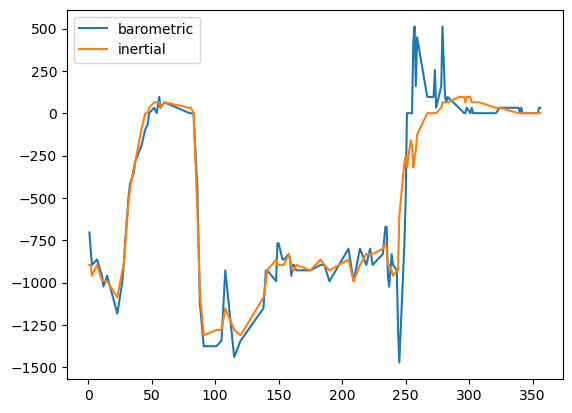

In [8]:
plt.plot(t[0].data.vertical_rate_barometric, label = "barometric")
plt.plot(t[0].data.vertical_rate_inertial, label = "inertial")
plt.legend()

In [12]:
# processing paper
t_processed = t.filter(vertical_rate_barometric = 3, vertical_rate_inertial = 3, strategy = None).agg_time("1min", vertical_rate_barometric = "std", vertical_rate_inertial = "std", latitude="mean", longitude = "mean").eval(desc = "")

Output()

In [14]:
#Criterion corrspond to Delta_VS.
#We see if there is turbulences by computing mean delta_VS + 1.2 std delta_VS

t_processed = t_processed.assign(criterion = lambda df: (df.vertical_rate_barometric_std - df.vertical_rate_inertial_std).abs())

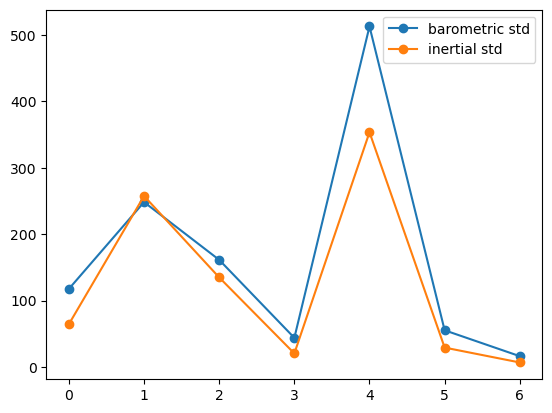

In [27]:
#as the std is over a window of 1min, it's a step function. We only take one value per step (unique())

plt.plot(t_processed[0].data.vertical_rate_barometric_std.unique(), label = "barometric std", marker = "o")
plt.plot(t_processed[0].data.vertical_rate_inertial_std.unique(), label = "inertial std", marker = "o")
plt.legend()

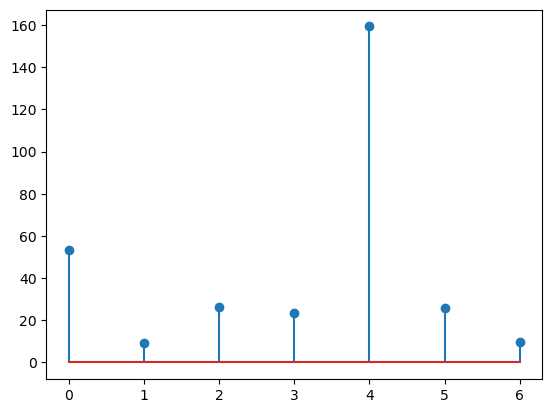

In [30]:
# for flight t[0], it seems there is a turbulence around min 4

y = t_processed[0].data.criterion.unique()
x = np.arange(len(y))

fig, ax = plt.subplots()
ax.stem(x, y)
plt.show()